# Generative Adversarial Networks


In [1]:
import pickle
import petname
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as fcnl
import torch.optim as optim
import torch.utils.data as data
import torch.utils.tensorboard as tensorboard
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
%matplotlib inline

### Dataset and Parameters


In [2]:
args = argparse.Namespace(
    name=petname.generate(), latent_size=16, num_epochs=5, batch_size=64,
    lr=0.001, betas=(0.5, 0.999), weight_decay=0, logdir='gan', file='gan.pkl'
)

dataset = datasets.FashionMNIST('mnist', True, transforms.ToTensor(), download=True)
dataloader = data.DataLoader(dataset, args.batch_size, shuffle=True)

### Generator and Discriminator Architecture

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = nn.ConvTranspose2d(latent_size, 32, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = z.view(-1, self.latent_size, 1, 1)
        x = fcnl.relu(self.bn1(self.conv1(z)))
        x = fcnl.relu(self.bn2(self.conv2(x)))
        x = fcnl.relu(self.bn3(self.conv3(x)))
        p = torch.sigmoid(self.conv4(x))
        return p 


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 4, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = fcnl.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = fcnl.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = fcnl.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        p = torch.sigmoid(self.conv4(x).view(-1))
        return p


## Training

In [4]:
gen = Generator(args.latent_size)
gen_optimiser = optim.Adam(gen.parameters(), lr=args.lr, betas=args.betas)

dsc = Discriminator()
dsc_optimiser = optim.Adam(dsc.parameters(), lr=args.lr, betas=args.betas)

writer = tensorboard.SummaryWriter(log_dir=f'{args.logdir}/{args.name}')
writer.add_text('args', str(vars(args)))
writer.add_graph(gen, torch.ones([args.batch_size, args.latent_size]))
writer.add_graph(dsc, torch.ones([args.batch_size, 1, 28, 28]))

z_random = torch.randn(64, args.latent_size)
z_interp = torch.zeros(64, args.latent_size)
grid_x, grid_y = torch.meshgrid([torch.linspace(-2, 2, 8), torch.linspace(-2, 2, 8)])
z_interp[:, 0] = grid_y.contiguous().view(-1)
z_interp[:, 1] = grid_x.contiguous().view(-1)

batch = 0
for epoch in range(args.num_epochs):
    for real_x, _ in dataloader:
        
        # Train discriminator to identify real data and output 1
        dsc_optimiser.zero_grad()
        real_y = dsc(real_x)
        real_loss = fcnl.binary_cross_entropy(real_y, torch.ones_like(real_y))
        real_loss.backward()

        # Train discriminator to identify fake data and output 0
        z = torch.randn(args.batch_size, args.latent_size)
        fake_x = gen(z)
        fake_y = dsc(fake_x.detach())
        fake_loss = fcnl.binary_cross_entropy(fake_y, torch.zeros_like(fake_y))       
        fake_loss.backward()
        dsc_optimiser.step()

        # Train generator to fool discriminator with fake data and make it output 1 
        gen_optimiser.zero_grad()
        fake_y = dsc(fake_x)
        fool_loss = fcnl.binary_cross_entropy(fake_y, torch.ones_like(fake_y))       
        fool_loss.backward()
        gen_optimiser.step()   

        writer.add_scalar('epoch', epoch, batch)
        writer.add_scalar('gan/dsc_real', real_loss.item(), batch)
        writer.add_scalar('gan/dsc_fake', fake_loss.item(), batch)
        writer.add_scalar('gan/gen_fool', fool_loss.item(), batch)
        writer.add_images('sample/random', 1 - gen(z_random))
        writer.add_images('sample/interp', 1 - gen(z_interp))
        if batch % 20 == 0:            
            print(f"Epoch: {epoch}|Batch: {batch}| L = {fool_loss.item():.2f}")
        batch += 1

with open(args.file, 'wb') as file:
    pickle.dump({'gen': gen, 'dsc': dsc}, file)
writer.close()


Epoch: 0|Batch: 0| L = 0.74
Epoch: 0|Batch: 20| L = 1.92
Epoch: 0|Batch: 40| L = 2.93
Epoch: 0|Batch: 60| L = 3.59
Epoch: 0|Batch: 80| L = 4.11
Epoch: 0|Batch: 100| L = 4.36
Epoch: 0|Batch: 120| L = 4.82
Epoch: 0|Batch: 140| L = 4.64
Epoch: 0|Batch: 160| L = 3.30
Epoch: 0|Batch: 180| L = 1.01
Epoch: 0|Batch: 200| L = 1.70
Epoch: 0|Batch: 220| L = 1.70
Epoch: 0|Batch: 240| L = 1.54
Epoch: 0|Batch: 260| L = 0.86
Epoch: 0|Batch: 280| L = 1.71
Epoch: 0|Batch: 300| L = 2.97
Epoch: 0|Batch: 320| L = 1.92
Epoch: 0|Batch: 340| L = 1.71
Epoch: 0|Batch: 360| L = 1.89
Epoch: 0|Batch: 380| L = 2.14
Epoch: 0|Batch: 400| L = 1.93
Epoch: 0|Batch: 420| L = 1.32
Epoch: 0|Batch: 440| L = 1.91
Epoch: 0|Batch: 460| L = 2.39
Epoch: 0|Batch: 480| L = 1.86
Epoch: 0|Batch: 500| L = 1.74
Epoch: 0|Batch: 520| L = 1.31
Epoch: 0|Batch: 540| L = 1.38
Epoch: 0|Batch: 560| L = 2.54
Epoch: 0|Batch: 580| L = 1.24
Epoch: 0|Batch: 600| L = 2.04
Epoch: 0|Batch: 620| L = 1.28
Epoch: 0|Batch: 640| L = 1.33
Epoch: 0|Batch: 

## Sampling

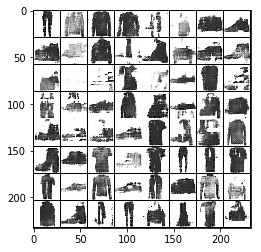

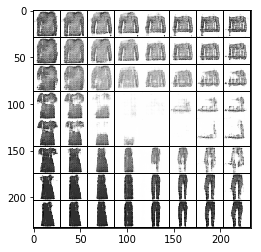

In [5]:
with open(args.file, 'rb') as file:
    gen_dsc = pickle.load(file)
    gen, dsc = gen_dsc['gen'], gen_dsc['dsc']

gen.eval()
with torch.no_grad():
    samples = utils.make_grid(1 - gen(z_random), padding=1)
    plt.imshow(samples.numpy().transpose([1, 2, 0]))
    plt.show()

    interps = utils.make_grid(1 - gen(z_interp), padding=1)
    plt.imshow(interps.numpy().transpose([1, 2, 0]))
    plt.show()
